In [1]:
# Necessário para exibir as imagens no notebook.
%matplotlib inline

https://anaconda.org/phios/pykalman
https://pykalman.github.io/

## Base de Dados

Valores de fechamento de duas ETF (Exchange-Traded Fund):
 - EWG, Alemanha;
 - EWC, Canadá.

Para coletar a variação dos índices dessas duas bolsas de valores vamos utilizar a função DataReader do pandas. Os dados serão coletados pela DataReader na base do Yahoo Finance, poderia ser o Google Finance ou qualuqer um outro listado na [documentação](http://pandas.pydata.org/pandas-docs/stable/remote_data.html).

De cada ação, ou índice, é possível coletar:
 - Open;
 - High;
 - Low;
 - Close;
 - Volume;
 - Adj Close

___
### Coletando os dados

In [8]:
from pandas.io.data import DataReader

# Selecionando as bolsas:
secs = ['EWA', 'EWC']  # Australia e Canada

# Coletando o valor ao fechamento (Adj Close)
data = DataReader(secs, 'yahoo', '2010-1-1', '2016-8-1')['Adj Close']

# Imprimindo o formato
print data.shape

# Imprimindo as 20 primeiras linhas
data[:20]

(1656, 2)


,EWA,EWC
Date,,
2010-01-04,17.553802,23.514414
2010-01-05,17.605606,23.645438
2010-01-06,17.672209,23.828872
2010-01-07,17.590805,23.750258
2010-01-08,17.798016,23.872546
2010-01-11,17.975627,23.802667
2010-01-12,17.383593,23.383391
2010-01-13,17.650008,23.619234
2010-01-14,17.872021,23.689114


### Visualizando a correlação entre os dados.

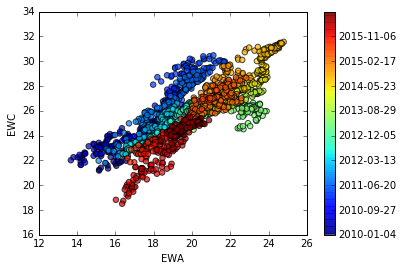

In [10]:
# Visualizando a correlacao entre os dados (precos ao londo tempo).
cm = plt.cm.get_cmap('jet')
dates = [str(p.date()) for p in data[::len(data)//10].index]
colors = np.linspace(0.1, 1, len(data))
sc = plt.scatter(data[data.columns[0]], data[data.columns[1]], s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in data[::len(data)//9].index]);
plt.xlabel(data.columns[0])
plt.ylabel(data.columns[1])
plt.savefig('price_corr.png')

### Construindo uma matriz de observação


In [3]:
import numpy as np

obs_mat = np.vstack([data.EWA, np.ones(data.EWA.shape)]).T[:, np.newaxis]
obs_mat[:10]

array([[[ 17.553802,   1.      ]],

       [[ 17.605606,   1.      ]],

       [[ 17.672209,   1.      ]],

       [[ 17.590805,   1.      ]],

       [[ 17.798016,   1.      ]],

       [[ 17.975627,   1.      ]],

       [[ 17.383593,   1.      ]],

       [[ 17.650008,   1.      ]],

       [[ 17.872021,   1.      ]],

       [[ 17.494599,   1.      ]]])

Definindo uma covariância de transição, quanto que a próxima observação será influenciada pela atual.

In [4]:
delta = 1e-5
trans_cov = delta / (1 - delta) * np.eye(2)

Finalmente, aplicando o filtro:

In [5]:
from pykalman import KalmanFilter

kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                  initial_state_mean=np.zeros(2),
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=1.0,
                  transition_covariance=trans_cov)

In [6]:
# and calculate the filtered state means and covariances
state_means, state_covs = kf.filter(data.EWC.values)

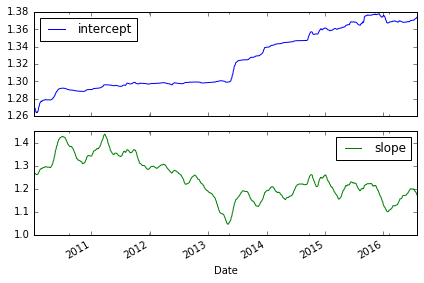

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Finally, we can plot the slope and intercept to see how they change over time 
pd.DataFrame(dict(slope=state_means[:, 0], intercept=state_means[:, 1]), index=data.index).plot(subplots=True)
plt.tight_layout();
plt.savefig('slope_intercept.png')

### Visualizando a correlação entre os dados + a regressão linear

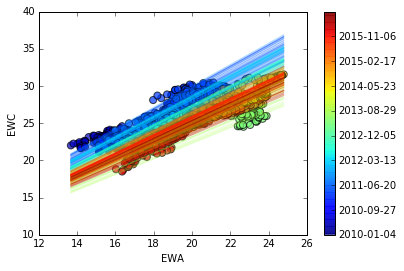

In [12]:
# Visualizando a correlacao entre os dados + a regressao linear
cm = plt.cm.get_cmap('jet')
dates = [str(p.date()) for p in data[::len(data)/10].index]
colors = np.linspace(0.1, 1, len(data))
sc = plt.scatter(data[data.columns[0]], data[data.columns[1]], s=50, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in data[::len(data)//9].index]);
plt.xlabel(data.columns[0])
plt.ylabel(data.columns[1])

# add as linhas da regressao
step = 5
xi = np.linspace(data[data.columns[0]].min(), data[data.columns[0]].max(), 2)
colors_l = np.linspace(0.1, 1, len(state_means[::step]))
for i, beta in enumerate(state_means[::step]):
    plt.plot(xi, beta[0] * xi + beta[1], alpha=.2, lw=1, c=cm(colors_l[i]))

plt.savefig('price_corr_regress.png')

Referência:
 - [[1](http://www.thealgoengineer.com/2014/online_linear_regression_kalman_filter/)] Online Linear Regression Kalman Filter